In [1]:
import numpy as np 
import pandas as pd 
from numba import njit
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import cv2 as cv
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from glob import glob
from skimage import io
from os import listdir
import pickle
import time
import copy

In [2]:
data = listdir('./breast-histopathology-images/IDC_regular_ps50_idx5/')

In [3]:
print(len(data))

279


In [4]:
base_path = './breast-histopathology-images/IDC_regular_ps50_idx5/'
patients = listdir(base_path)

In [5]:
patients[:5]

['10253', '10254', '10255', '10256', '10257']

In [6]:
class_0 = 0
class_1 = 0
for patient in patients:
    class_0_files = listdir(base_path + patient + '/0')
    class_1_files = listdir(base_path + patient + '/1')

    class_0 += len(class_0_files)
    class_1 += len(class_1_files) 

images = class_0 + class_1

In [7]:
class_0 

198740

In [8]:
class_1

78786

In [9]:
images

277526

In [10]:
data = pd.DataFrame(index=np.arange(0, images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(patients)):
    patient_id = patients[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,./breast-histopathology-images/IDC_regular_ps5...,0
1,10253,./breast-histopathology-images/IDC_regular_ps5...,0
2,10253,./breast-histopathology-images/IDC_regular_ps5...,0
3,10253,./breast-histopathology-images/IDC_regular_ps5...,0
4,10253,./breast-histopathology-images/IDC_regular_ps5...,0


In [11]:
data.tail()

,patient_id,path,target
277521,9383,./breast-histopathology-images/IDC_regular_ps5...,1
277522,9383,./breast-histopathology-images/IDC_regular_ps5...,1
277523,9383,./breast-histopathology-images/IDC_regular_ps5...,1
277524,9383,./breast-histopathology-images/IDC_regular_ps5...,1
277525,9383,./breast-histopathology-images/IDC_regular_ps5...,1


In [24]:
data.shape

(277526, 3)

In [13]:
data.dtypes

patient_id    object
path          object
target        object
dtype: object

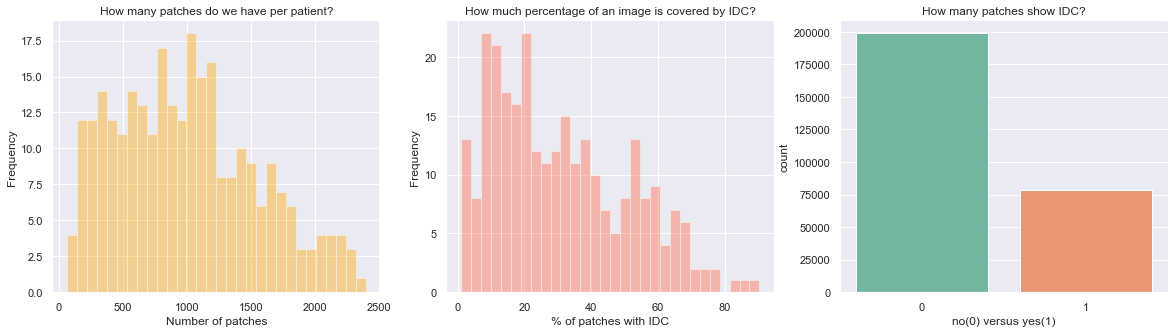

In [14]:
#got help from https://www.kaggle.com/allunia/breastcancer
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

In [15]:
data.target = data.target.astype(np.int)

In [22]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

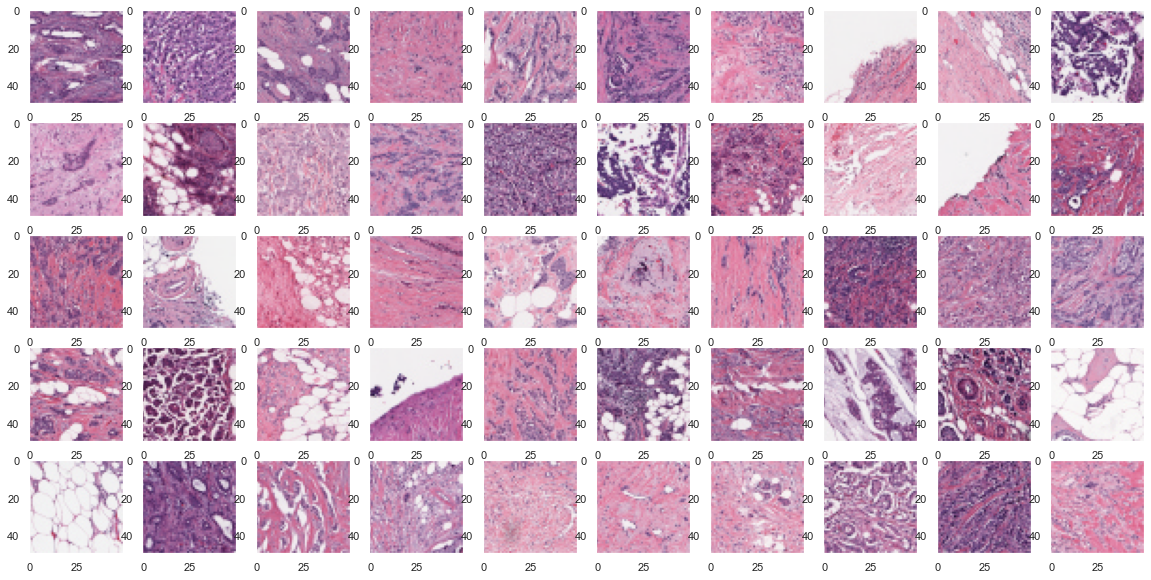

In [17]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
from skimage.io import imread
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

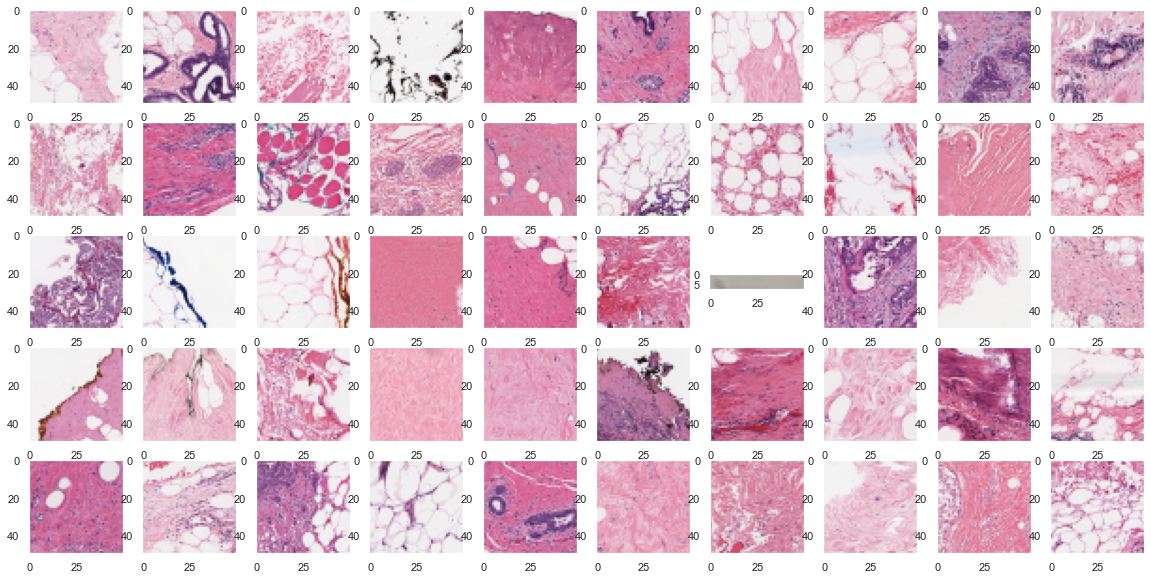

In [23]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [19]:
data.isnull().sum()

patient_id    0
path          0
target        0
dtype: int64

In [25]:
image_name = './breast-histopathology-images/10253/0/10253_idx5_x1001_y1001_class0.png'

In [29]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
   
# Initialising the ImageDataGenerator class. 
# We will pass in the augmentation parameters in the constructor. 
datagen = ImageDataGenerator( 
        rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5)) 
    
# Loading a sample image  
img = load_img(image_name)  
# Converting the input sample image to an array 
x = img_to_array(img) 
# Reshaping the input image 
x = x.reshape((1, ) + x.shape)  
   


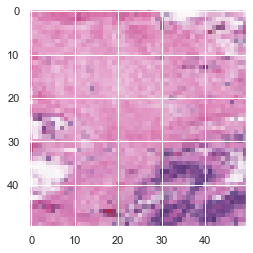

In [34]:
image = cv.imread(image_name)
image = cv.resize(image, (50,50))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

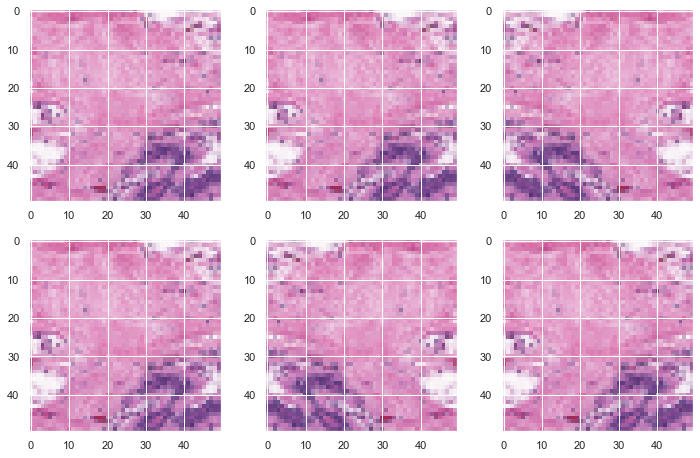

<Figure size 1440x720 with 0 Axes>

In [46]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img(image_name)
# convert to numpy array
pic = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(pic, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(6):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
plt.figure(figsize=(20,10))
pyplot.show()

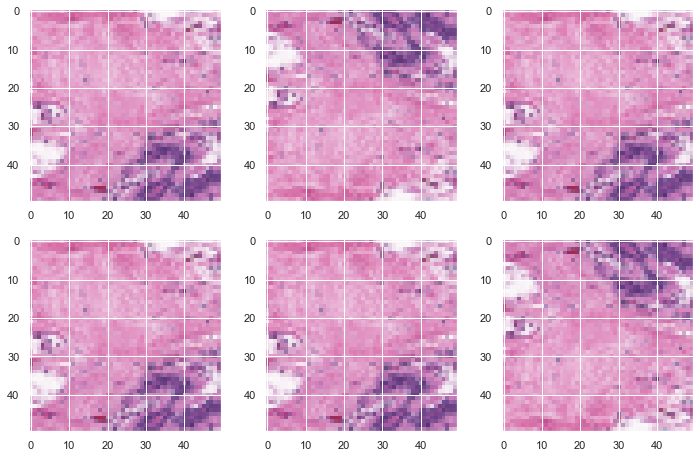

<Figure size 1440x720 with 0 Axes>

In [45]:
datagen = ImageDataGenerator(vertical_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(6):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
plt.figure(figsize=(20,10))
pyplot.show()

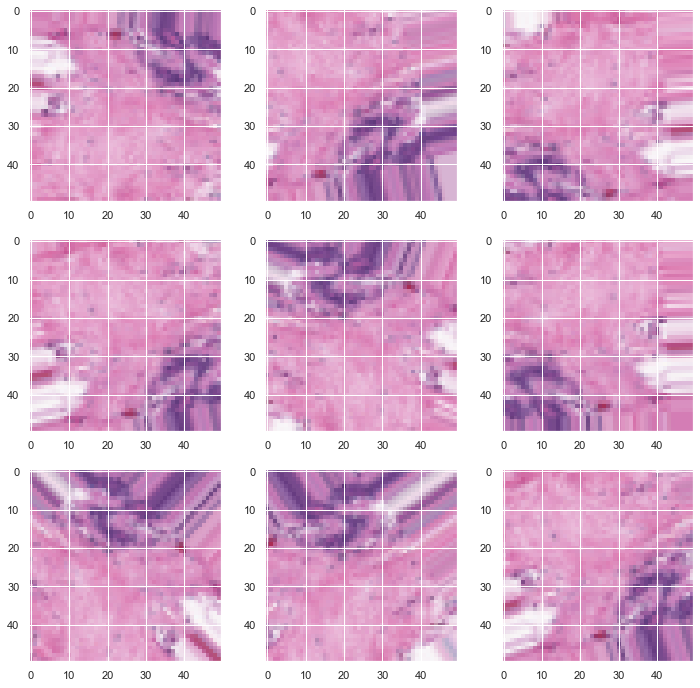

<Figure size 1440x720 with 0 Axes>

In [48]:
datagen = ImageDataGenerator( 
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
plt.figure(figsize=(20,10))
pyplot.show()

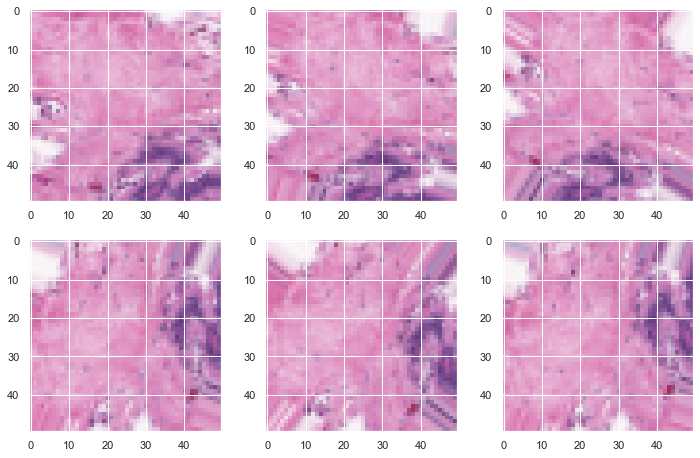

<Figure size 1440x720 with 0 Axes>

In [51]:
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(6):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
plt.figure(figsize=(20,10))
pyplot.show()